In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as sc


In [12]:

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

In [28]:
kobs_kadd_vals = pd.read_csv('hiv_kobs_kadd_vals_25_ACG.csv')
kobs_kadd_vals

temp = 25

kobs_kadd_vals['site_nt'] = kobs_kadd_vals['site'].astype(str) + kobs_kadd_vals['base'].astype(str)
kobs_kadd_vals['lnkobs_err'] = kobs_kadd_vals['lnkobs_err'].fillna(0)
kobs_kadd_vals['dG'] = kobs_kadd_vals.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[0], axis=1)
kobs_kadd_vals['dG_err'] = kobs_kadd_vals.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[1], axis=1)
kobs_kadd_vals['KKp1'] = kobs_kadd_vals.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[2], axis=1)
kobs_kadd_vals['KKp1_err'] = kobs_kadd_vals.apply(lambda x: calc_dG(x['lnkobs'], x['lnkobs_err'], x['lnkadd'], x['lnkadd_err'], temp, True)[3], axis=1)
#kobs_kadd_vals.to_csv('hiv_calc_dG.csv', index=False)
kobs_kadd_vals = kobs_kadd_vals[kobs_kadd_vals['base'].isin(['A', 'C'])]

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1997138387.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1997138387.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1997138387.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1997138387.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1321772999.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_11054/1321772999.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()
/v

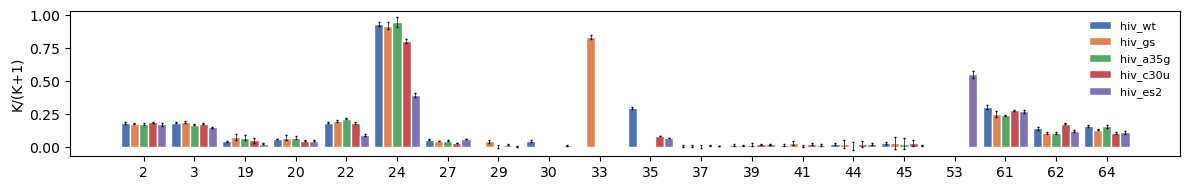

In [29]:
# Group by 'site' and compute mean dG and propagated error
def mean_with_error(group):
    dG_mean = group['KKp1'].mean()
    dG_err = np.sqrt((group['KKp1_err']**2).sum()) / len(group)
    return pd.Series({'KKp1_mean': dG_mean, 'KKp1_err_mean': dG_err})

# Set coalor palette manually
palette = sns.color_palette('deep', n_colors=5)
label_order = kobs_kadd_vals['disp_name'].unique()

# Sort sites numerically and define x positions
sorted_sites = sorted(kobs_kadd_vals['site'].unique())
x = np.arange(len(sorted_sites))

# Set figure
fig, ax = plt.subplots(figsize=(12, 2))

# Define bar width
bar_width = 0.18

# Loop through each group (disp_name)
for i, label in enumerate(label_order):
    df_subset = kobs_kadd_vals[kobs_kadd_vals['disp_name'] == label]

    # sites with data
    sites_with_data = df_subset['site'].unique()
    missing_sites = set(sorted_sites) - set(sites_with_data)
    for site in missing_sites:
        # fill columns with nan: ['site', 'disp_name', 'lnkobs', 'lnkobs_err', 'lnkadd', 'lnkadd_err', 'base', 'site_nt', 'dG', 'dG_err']
        df_subset = pd.concat([df_subset, pd.DataFrame({'site': [site], 'disp_name': [label], 'lnkobs': [np.nan], 'lnkobs_err': [np.nan], 'lnkadd': [np.nan], 'lnkadd_err': [np.nan], 'base': [np.nan], 'site_nt': [np.nan], 'dG': [np.nan], 'dG_err': [np.nan]})], ignore_index=True)

    # Align to sorted x-axis positions
    df_subset = df_subset.set_index('site').loc[sorted_sites].reset_index()

    # Calc mean dG
    meanDG_df = df_subset.groupby('site').apply(mean_with_error).reset_index()

    offset = (i - 2) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
    ax.bar(x + offset, meanDG_df['KKp1_mean'], yerr=meanDG_df['KKp1_err_mean'],
           width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=1, error_kw={'linewidth': 0.5})

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(sorted_sites)
ax.set_xlabel('')
ax.set_ylabel(r'K/(K+1)')
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
#plt.savefig('hiv_calc_dG.pdf')

In [16]:
sorted_sites

[np.int64(2),
 np.int64(3),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(24),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(39),
 np.int64(41),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(53),
 np.int64(54),
 np.int64(61),
 np.int64(62),
 np.int64(64)]